# This is the project in Optimization 1

In [183]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt
# from numpy.random import default_rng
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.datasets import load_iris
import math

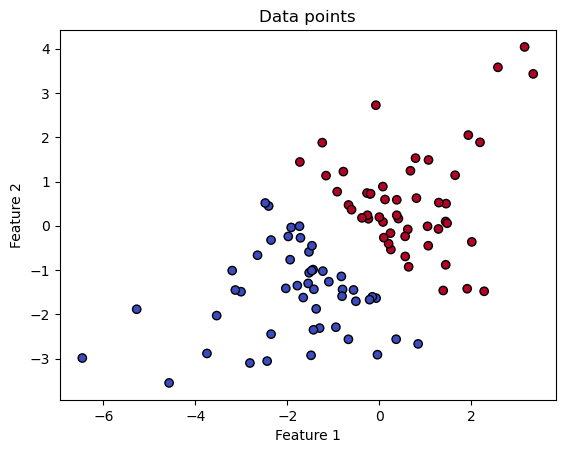

In [222]:
np.random.seed(42)
w = np.array([1.,1.])
b = 1.

n = 100
n_A = np.random.randint(0,n)
n_B = n-n_A
margin = 5.e-1
listA, listB = TestLinear(w,b,n_A,n_B,margin)

x = np.concatenate((np.array(listA),np.array(listB)))

y = np.concatenate((np.ones(n_A), -np.ones(n_B)))

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("Data points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.show()


In [62]:

alpha0 = np.zeros(n_A+n_B)
tau = 1
niter = 1000
C = 3
G = pairwise_kernels(x, metric = kernal_linear)  

alpha = gradient_descent(alpha0, G, y, tau0=tau, niter=niter, C=C, tol=1e-7, projection=projection)

w, b = w_b(alpha, y,x ,  C=C)
plot_solution(x, y, w, b)


C = 45
G = pairwise_kernels(x, metric = kernal_linear)  

alpha = gradient_descent(alpha0, G, y, tau0=tau, niter=niter, C=C, tol=1e-7, projection=projection)

w, b = w_b(alpha, y,x ,  C=C)
plot_solution(x, y, w, b)

Iteration 0 : 1.52


KeyboardInterrupt: 

In [ ]:

alpha0 = np.zeros(n_A+n_B)
tau = 1
niter = 1000
C = 5
G = pairwise_kernels(x, metric = kernal_linear)


alpha = gradient_descent(alpha0, G, y, tau0=tau, niter=niter, C=C, tol=1e-7, projection=projection)
alphagrad, fks = gradient_descent_linesearch(alpha0, G, y, tau0=tau, niter=niter, C=C, tol=1e-7, project=projection)

w, b = w_b(alpha, y,x ,  C=C)
plt.title("Gradient descent without linesearch")
plot_solution(x, y, w, b)

w, b = w_b(alphagrad, y,x ,  C=C)
plt.title("Gradient descent with linesearch")
plot_solution(x, y, w, b)


plot_db(x, y, alpha, ker = kernal_linear, C=C)

In [ ]:
plot_db(x, y, alphagrad, ker = kernal_linear, C=C)

### Testing the different kernels

In [ ]:
niter = 1000
C = 5

G = pairwise_kernels(x, metric = kernal_gaussian, sigma=1)
alpha = gradient_descent(alpha0, G, y, tau, niter, C)
# w, b = w_b(alpha, y, x, C=C)
# plot_solution(x, y, w, b)
plot_db(x, y, alpha, ker = kernal_gaussian, C=C)    

G = pairwise_kernels(x, metric = kernal_inv_multiquadratic, sigma=1)
alpha = gradient_descent(alpha0, G, y, tau, niter, C)
# w, b = w_b(alpha, y, x, C=C)
# plot_solution(x, y,  w, b)
plot_db(x, y, alpha, ker = kernal_inv_multiquadratic, C=C)

G = pairwise_kernels(x, metric = kernal_laplacian, sigma=1)
alpha = gradient_descent(alpha0, G, y, tau, niter, C)
# w, b = w_b(alpha, y, x, C=C)
# plot_solution(x, y,  w, b)
plot_db(x, y, alpha, ker = kernal_laplacian, C=C)



In [ ]:

alpha0 = np.ones(n_A+n_B)
tau = 1
niter = 1000
C = 3
G = pairwise_kernels(x, metric = kernal_linear)


alpha_test1, fks = gradient_descent_linesearch(alpha0, G, y, tau, niter=niter, C=0.8, L=10, tol=1e-5, project=projection)
alpha_test2 = gradient_descent(alpha0, G, y, tau, niter=niter, C=0.8, tol=1e-3)


In [ ]:
alpha0 = np.ones(n_A+n_B)*0.5

alpha_test1, fks = gradient_descent_linesearch(alpha0, G, y, tau, niter=1000, C=0.8, L=10, tol=1e-5)
alpha_test2 = gradient_descent(alpha0, G, y, tau, niter=1000, C=0.8, tol=1e-3)

In [ ]:
# ker = kernal_linear
ker = kernal_gaussian
ker = kernal_inv_multiquadratic
# ker = kernal_laplacian
C = 1
G = pairwise_kernels(x, metric = ker)  

# np.random.seed(42)
alpha, f = gradient_descent_linesearch(alpha0, G, y, tau0=tau, niter=niter, C=C, tol=1e-7, project=projection)

plot_db(x, y, alpha, ker)

### Testing with random initial contitions

In [ ]:
alpha0 = np.random.rand((n_A+n_B))
ker = kernal_gaussian
G = pairwise_kernels(x, metric = ker)  

niter = 1000
C = 5
alpha_line, fk = gradient_descent_linesearch(alpha0, G, y, tau, niter, C = C, L=10, tol=1e-7)
alpha_grad = gradient_descent(alpha0, G, y, tau, niter, C=C, tol=1e-7)

plot_db(x, y, alpha_line, ker, C=C)
plot_db(x, y, alpha_grad, ker, C=C)


### Using gradient descent on the iris dataset

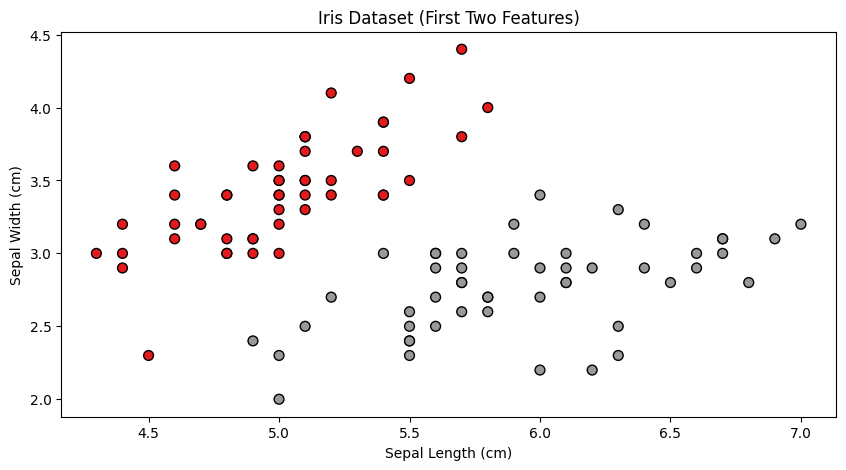

Iteration 0 : 1.0


KeyboardInterrupt: 

In [32]:
iris = load_iris()
X = iris.data[:, :2][0:100]  # We'll use only the first two features for visualization
Y = iris.target[0:100]  
Y[Y == 0] = -1  # Convert to -1 and 1 for SVM
Y[Y == 1] = 1


plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Set1, s=50, edgecolors='k')
plt.title('Iris Dataset (First Two Features)')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.show()

alpha0 = np.zeros(len(Y))
ker = kernal_gaussian
G = pairwise_kernels(X, metric=ker)
C= 100

alpha, f = gradient_descent_linesearch(alpha0, G, Y, tau0=tau, niter=niter, C=C, L=10, tol=1e-7, project=projection)

plot_db(X, Y, alpha, ker=ker, C=C)

In [63]:
def projection_AL(vector, proj_par):
    lower_bounds = proj_par[0]
    upper_bounds = proj_par[1]
    dimension = len(vector)
    proj_vector = np.array([])
    
    for k in range(0, dimension):
        if vector[k]<lower_bounds[k]:
            proj_vector = np.append(proj_vector, np.array([lower_bounds[k]]))
        elif vector[k] > upper_bounds[k]:
            proj_vector = np.append(proj_vector, np.array([upper_bounds[k]]))
        else:
            proj_vector = np.append(proj_vector, np.array([vector[k]]))
    return proj_vector

In [105]:
def BCLM(vec_0, lambd_0, mu_0, tol_1, tol_2, maxiter, func, func_par, constr, constr_par, grad, grad_par, project, project_par, linesearch, linesearch_par): #Algoritme 17.4 i boka
    
    tol_1_k = 1/mu_0
    tol_2_k = 1/mu_0**(0.1)

    vec_k = vec_0
    lambd_k = lambd_0
    mu_k = mu_0

    grad_par[0] = lambd_k
    grad_par[1] = mu_k
    func_par[0] = lambd_k
    func_par[1] = mu_k

    tau_0 = 1
    tau = tau_0

    for _ in range(0, maxiter):
        print("iterasjon BCLM",_)
    
        projected_gradient_method = general_projected_gradient_linesearch(vec_k, tau, func, func_par, grad, grad_par, project, project_par, linesearch, linesearch_par, tol = tol_1_k, L = 10)

        vec_k= projected_gradient_method[0]
        d_k_norm = projected_gradient_method[2]
        tau = projected_gradient_method[3]

        c_k = constr(vec_k, constr_par)
        c_k_norm = np.linalg.norm(c_k)
        #print(vec_k,"vecc BCL;")
        print(c_k_norm,"ck")

        if c_k_norm <= tol_2_k:
            print("ck mindre")
            if c_k_norm <= tol_2 and d_k_norm <= tol_1:
                return vec_k, lambd_k
            
            lambd_k = lambd_k - mu_k*c_k
            tol_1_k = tol_1_k/mu_k
            tol_2_k = tol_2_k/mu_k**(0.9)
            print(tol_1_k,tol_2_k,"tols")

            grad_par[0] = lambd_k
            func_par[0] = lambd_k
            linesearch_par[0] = lambd_k

        
        else:
            print("else")
            mu_k = 100*mu_k
            tol_1_k = 1/mu_k
            tol_2_k = 1/mu_k**(0.1)
            print(tol_1_k,tol_2_k,"tols")
            grad_par[1] = mu_k
            func_par[1] = mu_k
            linesearch_par[1] = mu_k

    return "Ingen konvergens"


In [32]:
def AL(vec, AL_par): #kontroller at dette er rett

    lambd = AL_par[0]
    mu = AL_par[1]

    d = AL_par[2]
    M = AL_par[3]

    x = AL_par[4]
    y = AL_par[5]

    C = AL_par[6]
    # print(vec,"al")
    w = vec[0:d]
    b = vec[d]
    xi = vec[d+1:d+1+M]
    s = vec[d+1+M:]
    
    AL = 0.5*np.linalg.norm(w)**2
    for i in range(0, len(xi)):
        indreprod = np.inner(w, x[i])
        AL = AL + C*xi[i] - lambd[i]*(y[i]*(indreprod + b) + xi[i] - s[i] - 1) + 0.5*mu*(y[i]*(indreprod + b) + xi[i] - s[i] - 1)**2
    return AL

#print(AL(np.array([1,1]),1, np.array([1,1]),np.array([1,1]), np.array([1,1]), 2, np.array([np.array([1,1]), np.array([1,1])]), np.array([1,1]), 1))

In [188]:
from scipy.optimize import approx_fprime
epsilon = 1e-8



In [145]:
def AL_wrapper(vec):
    return AL(vec, AL_par)

# Pick a random vec to test
vec_test = np.random.randn(d + 1 + 2*M)

# Compute analytic gradient
grad_analytic = grad_AL(vec_test, AL_par)

# Compute numerical gradient
grad_numerical = approx_fprime(vec_test, AL_wrapper, epsilon)

# Compare
print("Analytic gradient:", grad_analytic)
print("Numerical gradient:", grad_numerical)
print("Difference:", np.linalg.norm(grad_analytic - grad_numerical))

Analytic gradient: [-1.06203658e+05 -1.23171823e+05  3.11316450e+04 -3.68484648e+03
 -1.62886281e+03 -4.34247296e+03 -3.67464350e+03 -3.27200815e+03
 -5.31682810e+03 -3.12620507e+03 -2.35136140e+03 -4.64360870e+03
 -2.21466971e+03 -4.69569937e+03 -2.55080856e+03 -2.22967261e+03
 -1.13679385e+02 -4.89508856e+03 -3.41661572e+03 -5.97502955e+03
 -6.31806784e+02 -4.08533220e+03 -1.13217293e+04  3.78484648e+03
  1.72886281e+03  4.44247296e+03  3.77464350e+03  3.37200815e+03
  5.41682810e+03  3.22620507e+03  2.45136140e+03  4.74360870e+03
  2.31466971e+03  4.79569937e+03  2.65080856e+03  2.32967261e+03
  2.13679385e+02  4.99508856e+03  3.51661572e+03  6.07502955e+03
  7.31806784e+02  4.18533220e+03  1.14217293e+04]
Numerical gradient: [-1.06203653e+05 -1.23171823e+05  3.11316459e+04 -3.68484764e+03
 -1.62885991e+03 -4.34247193e+03 -3.67464384e+03 -3.27200394e+03
 -5.31682745e+03 -3.12620541e+03 -2.35136248e+03 -4.64360931e+03
 -2.21466762e+03 -4.69569935e+03 -2.55080521e+03 -2.22967354e+03
 

In [21]:
def grad_ny(vec,param):
    AL_par=param                  
    return approx_fprime(vec,AL_wrapper,epsilon)

In [128]:
def grad_AL(vec, gradAL_par): #Kontroller at dette er rett
    
    lambd = gradAL_par[0]
    mu = gradAL_par[1]

    d = gradAL_par[2]
    M = gradAL_par[3]

    x = gradAL_par[4]
    y = gradAL_par[5]

    C = gradAL_par[6]

    w = vec[0:d]
    b = vec[d]
    xi = vec[d+1:d+1+M]
    s = vec[d+1+M:]
    
    grad_AL = np.array([])
    
    #Elements from w
    for k in range(0, d):
        grad_k = w[k]
        for i in range(0, M):
            indresum = 0
            for l in range(0, d):
                indresum = indresum + 2*x[i][k]*x[i][l]*w[l]
            grad_k = grad_k - lambd[i]*y[i]*x[i][k] + 0.5*mu*(y[i]**2 * indresum + 2*y[i]**2 * b * x[i][k] + 2*y[i]*xi[i]*x[i][k] - 2*y[i]*s[i]*x[i][k] -2*y[i]*x[i][k])
        grad_AL = np.append(grad_AL, np.array([grad_k]))
    
    #Elements from b
    grad_b = 0
    for i in range(0, M):
        grad_b = grad_b - lambd[i]*y[i] + 0.5*mu*(2*y[i]**2*b + 2*y[i]**2*np.inner(w, x[i]) + 2*y[i]*xi[i] - 2*y[i]*s[i] - 2*y[i])
    grad_AL = np.append(grad_AL, np.array([grad_b]))

    #Elements from xi
    for i in range(0, M):
        grad_xi = C - lambd[i] + 0.5*mu*(2*xi[i] + 2*y[i]*np.inner(w, x[i]) + 2*y[i]*b - 2*s[i] - 2)
        grad_AL = np.append(grad_AL, np.array([grad_xi]))

    #Elements from s
    for i in range(0, M):
        grad_s = +lambd[i] + 0.5*mu*(2*s[i] - 2*y[i]*np.inner(w, x[i]) - 2*y[i]*b - 2*xi[i] + 2)
        grad_AL = np.append(grad_AL, np.array([grad_s]))
    
    return grad_AL

#print(grad_AL(np.array([1,1]),1, np.array([1,1]),np.array([1,1]), np.array([1,1]), 2, np.array([np.array([1,1]), np.array([1,1])]), np.array([1,1]), 1))

In [338]:
def general_projected_gradient_linesearch(vec_0, tau_0, func, func_par, grad, grad_par, project, project_par, linesearch, linesearch_par, tol, L = 10):

    vec = vec_0
    tau = tau_0
    
    f_ref = np.inf
    f_best = func(vec, func_par)
    f_c = f_best
    ell = 0
    f_ks = np.zeros(niter)

    lin = 0

    for i in range(niter):

        d_k = project(vec -  tau*grad(vec, grad_par), project_par) - vec
        d_k_norm = np.linalg.norm(d_k)/tau #Me deler på tau pga artikkelen

        if d_k_norm < tol:
            print("Converged after", i, "iterations")
            print("d_k fire fyrste", d_k[0:4])
            print("siste f", f_ks[i-1])
            print("lin", lin)
            return vec, f_ks, d_k_norm, tau
        
        if  i%100 == 0:
            print("Iteration", i, ":", d_k_norm) 
        
        f_k = func(vec, func_par)
        f_ks[i] = f_k
        if f_k < f_best:
            f_best = f_k
            f_c = f_k
            ell = 0
        else:
            f_c = np.max([f_c, f_k])
            ell = ell + 1
        if ell == L:
            f_ref = f_c
            f_c = f_k
            ell = 0

        print("f", func(vec + d_k, func_par))
        
        if  func(vec + d_k, func_par) > f_ref:
            lin = lin + 1
            theta = linesearch(vec, d_k, linesearch_par)
            
        else:
            theta = 1

        vec_temp=vec
        vec = vec + theta * d_k

        tau = general_BB_steplength(vec-theta*d_k, vec, grad, grad_par, taumax=1e5, taumin=1e-5)

    #print("siste f", f_ks[i-1])

    print("Did not converge after", niter, "iterations", "tol=", tol)
    
    return vec, f_ks, d_k_norm, tau

In [26]:
def general_BB_steplength(vec_k, vec_k1, grad, grad_par, taumax=1e5, taumin=1e-5):
    nevner = np.dot((vec_k1 - vec_k), (grad(vec_k1, grad_par) - grad(vec_k, grad_par)))
    if  nevner<= 0:
        return taumax
    tau = np.dot((vec_k1 - vec_k), (vec_k1 - vec_k)) / nevner
    return max(min(tau, taumax), taumin)


In [27]:
def linesearch_AL(vec, d_k, linesearch_par):
    
    lambd = linesearch_par[0]
    mu = linesearch_par[1]

    d = linesearch_par[2]
    M = linesearch_par[3]

    x = linesearch_par[4]
    y = linesearch_par[5]

    C = linesearch_par[6]
    # print(vec,"line")
    w = vec[0:d]
    b = vec[d]
    xi = vec[d+1:d+1+M]
    s = vec[d+1+M:]

    d_w = d_k[0:d]
    d_b = d_k[d]
    d_xi = d_k[d+1:d+1+M]
    d_s = d_k[d+1+M:]
    
    A = np.linalg.norm(d_k[0:d],2)**2
    B = np.inner(w, d_w) + C*np.sum(d_xi)

    for i in range(0, M):
        indprod_1 = np.inner(d_w, x[i])
        indprod_2 = np.inner(w, x[i])
        
        A = A + mu* (indprod_1**2 + d_k[d]**2 + d_k[d+i]**2 + d_k[d+M+i]**2 + 2*d_k[d]*indprod_1 + 2*y[i]*d_k[d+i]*indprod_1 - 2*y[i]*d_k[d+M+i]*indprod_1 + 2*y[i]*d_k[d]*d_k[d+i] - 2*y[i]*d_k[d]*d_k[d+M+i] - 2*d_k[d+i]*d_k[d+M+i])

        B = B - lambd[i]* (y[i]*(indprod_1 + d_k[d]) + d_k[d+i] - d_k[d+M+i]) + mu*(indprod_2 * indprod_1 + b*d_k[d] + xi[i]*d_k[d+i] + s[i]*d_k[d+M+i] + b*indprod_1 + d_k[d]*indprod_2 + y[i]*xi[i]*indprod_1 + y[i]*d_k[d+i]*indprod_2 - y[i]*s[i]*indprod_1 - y[i]*d_k[d+M+i]*indprod_2 - y[i]*indprod_1 + y[i]*d_k[d]*xi[i] + y[i]*d_k[d+i]*b - y[i]*d_k[d+M+i]*b - y[i]*d_k[d]*s[i] - y[i]*d_k[d] - d_k[d+i]*s[i] - d_k[d+M+i]*xi[i])
    
    theta = -B/A

    return theta


In [182]:
d = len(x[0])
M = len(x)

C = 100

startpunkt = np.ones(d+1+2*M)
lambd_0 = np.ones(M)*10
mu_0 = 10
tol_1 = 1e-5
tol_2 = 1e-5
maxiter = 1000
niter = 2000

AL_par = [lambd_0, mu_0, d, M, x, y, C]
gradAL_par = [lambd_0, mu_0, d, M, x, y, C]
constr_par = [x, y]

lower_bound = np.append([- np.inf]*(d+1), [0]*2*M)
upper_bound = [np.inf]*(d+1+2*M)
project_par = [lower_bound, upper_bound]
                                         
linesearch_par = [lambd_0, mu_0, d, M, x, y, C]

BCLM(startpunkt, lambd_0, mu_0, tol_1, tol_2, maxiter, AL, AL_par, constraints, constr_par, grad_AL, gradAL_par, projection_AL, project_par, linesearch_AL, linesearch_par)

iterasjon BCLM 0
Iteration 0 : 309.2792001788609
Iteration 100 : 6.653041147676982
Iteration 200 : 4.506650088193601
Converged after 254 iterations
d_k fire fyrste [ 5.92430251e-05  1.02283430e-04 -4.75325484e-05  0.00000000e+00]
siste f -93.18153797992856
4.353670268583438 ck
else
0.001 0.5011872336272722 tols
iterasjon BCLM 1
Iteration 0 : 32707.79506859408
Iteration 100 : 5403.414711185558
Iteration 200 : 1309.2434389806049
Iteration 300 : 203149.25069283435
Iteration 400 : 0.5928733589967227
Iteration 500 : 0.7533653824288387
Iteration 600 : 0.46464369914384773
Iteration 700 : 12.68825353292056
Iteration 800 : 1.5999964711479748
Iteration 900 : 149034.6236193035
Iteration 1000 : 175049.82393475782
Iteration 1100 : 121973.68547277109
Iteration 1200 : 113543.18610847511
Iteration 1300 : 110639.57553451904
Iteration 1400 : 108897.62072328814
Iteration 1500 : 107655.59871054445
Iteration 1600 : 106690.36816484218
Iteration 1700 : 105177.14522887583
Iteration 1800 : 103911.94396705215
I

KeyboardInterrupt: 

In [102]:
def constraints(vec, constr_par):

    d = 2 #len(x[0])
    M = len(x)


    w = vec[0:d]
    b = vec[d]
    xi = vec[d+1:d+M+1]
    s = vec[d+M+1:]

    c_vec = np.array([])
    for i in range(0, len(x)):
        c_vec = np.append(c_vec, np.array([y[i]*(np.inner(w, x[i]) + b) + xi[i] -s[i]-1]))
    
    return c_vec

In [334]:
def logloss(vec, par): #vec = [w, b], par = [x, y, C]
    
    x = par[0]
    y = par[1]
    C = par[2]

    d = len(x[0])
    M = len(x)

    logloss = 0.5*np.linalg.norm(vec[0:d])**2
    for i in range(0,M):
        logarg = y[i]*(np.inner(vec[0:d], x[i]) + vec[d])
        #if logarg > 1000:
            #print("logarg:", logarg, "exp:", np.exp(-logarg), "1+exp:", 1 + np.exp(-logarg), "log:", np.log(1 + np.exp(-logarg)), "Clog:", C*np.log(1 + np.exp(-logarg)))
        logloss = logloss + C*np.log(1 + np.exp(-logarg))
    
    return logloss

startpunkt = np.ones(d + 1)*10
par = [x, y, C, ker]

print(logloss(startpunkt, par))

100.78118879420043


In [353]:
def grad_logloss(vec, par): #vec = [w, b], par = [x, y, C]

    x = par[0]
    y = par[1]
    C = par[2]

    d = len(x[0])
    M = len(x)

    w = vec[0:d]
    b = vec[d]

    grad = np.zeros(d+1)
    
    #Det som kjem frå w
    for k in range(0, d):
        grad_k = vec[k]
        for i in range(0, M):
            expo = np.exp(-y[i]*(np.inner(w, x[i]) + b))
            grad_k = grad_k - C*y[i]*x[i][k]*expo/(1+expo)
        grad[k] = grad_k
    
    #Det som kjem frå b
    grad_b = 0
    for i in range(0, M):
        expo = np.exp(-y[i]*(np.inner(w, x[i]) + b))
        grad_b = grad_b - C*y[i]*expo/(1+expo)
    grad[d] = grad_b

    return grad

parame = [np.array([np.array([1,1]), np.array([1,1])]), np.array([1,1]), 5]
print(grad_logloss(np.array([1,1,1]), parame))

[ 0.52574127  0.52574127 -0.47425873]


In [354]:
def logloss_kernel(vec, par): #[x, y, C, kernel]
    
    x = par[0]
    y = par[1]
    C = par[2]

    d = len(x[0])
    M = len(x)

    ker = par[3]

    logloss = 0.5*np.linalg.norm(vec[0:d])**2
    for i in range(0,M):
        inner = pairwise_kernels([vec[0:d]], [x[i]], ker)[0][0]
        logarg = y[i]*(inner + vec[d])
        logloss = logloss + C*np.log(1 + np.exp(-logarg))
    
    return logloss

startpunkt = np.ones(d + 1)*10
ker = kernal_gaussian
par = [x, y, C, ker]

print(logloss_kernel(startpunkt, par))

49100.45398899218


In [266]:
def grad_logloss_ny(vec, param):
    def logloss_wrapper(vec):
        return logloss(vec, param)                 
    return approx_fprime(vec,logloss_wrapper,epsilon)

startpunkt = np.ones(d + 1)*10
ker = kernal_gaussian
par = [x, y, C, ker]

print(grad_logloss(startpunkt, par))

[ 9.95399715  9.65650531 -0.21743865]


Iteration 0 : 23.273527121797603
f 34492.09488586538
f 1152.1317889021093
f 484.1648394195927
f 473.2758625448246
f 215.385086362357
f 25502.522920298074
f 345.52804866829587
f 308.97811094420763
f 251.50908891259266
f 221.3308387145123
f 189.78615617782276
f 145.73320310269216
f 164.45634588097525
f 221.86148963147497
f 112.10370956063304
f 103.3513183901564
f 902.391719107155
f 197.74363625339547
f 112.95709677178466
f 103.72415877500835
f 88.33829981700924
f 72.70632077408874
f 69.84361151045768
f 64.71795739221885
f 59.18649893531349
f 58.20800913315602
f 55.75508560573567
f 54.754125598838314
f 54.40088334814283
f 54.14117893106614
f 54.14950359057938
f 54.08435512562111
f 53.92572324013519
f 53.919370910640275
f 53.9067377091432
f 53.9061712625607
f 53.91698790924339
f 53.90485752882557
f 53.90485713986262
f 53.904857138000914
f 53.90485713404186
f 53.90485713330452
f 53.90485713355978
f 53.90485713329454
Converged after 44 iterations
d_k fire fyrste [-5.85266777e-08 -5.36958504e

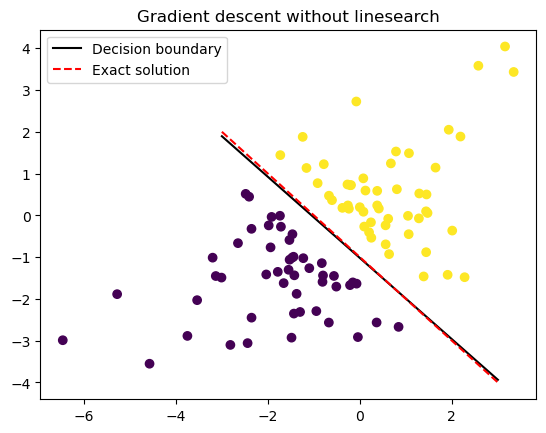

In [380]:
def project_logloss(vec, par): #[w, b], #[kva som helst]
    return vec

startpunkt = np.array([0.9, 1.1, 1])*(6)
ker = kernal_linear
par = [x, y, C]#, ker]
tau_0 = 1
f = logloss
f_par = par
grad_f = grad_logloss
grad_par = par
rho = 0.95
c = 0.5
alpha_0 = 1
project = project_logloss
linesearch = linesearch_numeric
linesearch_par = [rho, c, alpha_0, f, f_par, grad_f, grad_par]


løysing = general_projected_gradient_linesearch(startpunkt, tau_0, f, f_par, grad_f, grad_par, project, [0], linesearch, linesearch_par, tol = 1e-5, L = 10)[0]

w = løysing[0:d]
b = løysing[d]

print("w", w)
print("b", b)

plt.title("Gradient descent without linesearch")
plot_solution(x, y, w, b)

In [369]:

def linesearch_numeric(vec,d_k,linesearch_par): #[rho, c, alpha0, f, f_par, grad_f, grad_f_par]

    rho = linesearch_par[0]
    c = linesearch_par[1]
    alpha = linesearch_par[2]
    f=linesearch_par[3]
    f_par = linesearch_par[4]
    grad_f=linesearch_par[5]
    grad_f_par = linesearch_par[6]

    grad_f = grad_f(vec, grad_f_par)

    print("test_1", f(vec, f_par))
    print("test_2", c*alpha*np.dot(grad_f,d_k))

    while f(vec-alpha*d_k, f_par)<=f(vec, f_par)+c*alpha*np.dot(grad_f,d_k):
        alpha=alpha*rho

    return alpha